In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [92]:
habi_df = pd.read_excel('dataset.xlsx')

In [93]:
habi_df.head()

,id,birth_date,terms_conditions,gender,meta,date_exp_token,id.1,contact_id,type_occupation_id,type_independent_activity_id,...,company_phone,company_city_id,name,label,is_active,activity_code,name.1,label.1,viability,is_selected
0,1767,1998-05-30,1,NaN,NaN,2022-11-25 23:13:29.0,5,1767,1,1,...,NaN,NaN,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,1,0
1,1767,1998-05-30,1,NaN,NaN,2022-11-25 23:13:29.0,5,1767,1,1,...,NaN,NaN,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,0,0
2,23963,1984-07-08,0,NaN,NaN,2023-01-16 18:16:50.0,4547,23963,1,1,...,NaN,NaN,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,1,1
3,23965,1985-02-14,0,NaN,NaN,NaN,4549,23965,1,1,...,NaN,NaN,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,1,1
4,24370,1997-01-09,0,NaN,NaN,NaN,4860,24370,1,1,...,NaN,NaN,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,1,1


<Axes: >

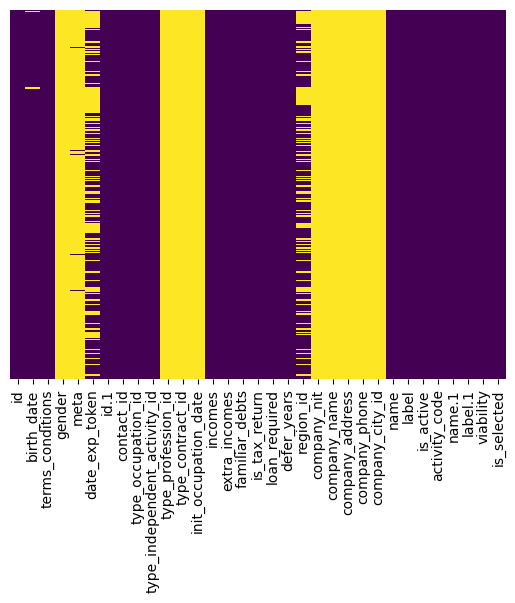

In [94]:
sns.heatmap(habi_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

No son utiles: 
gender
meta
type_profession_id
type_contract_id
init_occupation_date
company_nit
company_name
company_address
company_phone
company_city_id

In [95]:
habi_df.columns

Index(['id', 'birth_date', 'terms_conditions', 'gender', 'meta',
       'date_exp_token', 'id.1', 'contact_id', 'type_occupation_id',
       'type_independent_activity_id', 'type_profession_id',
       'type_contract_id', 'init_occupation_date', 'incomes', 'extra_incomes',
       'familiar_debts', 'is_tax_return', 'loan_required', 'defer_years',
       'region_id', 'company_nit', 'company_name', 'company_address',
       'company_phone', 'company_city_id', 'name', 'label', 'is_active',
       'activity_code', 'name.1', 'label.1', 'viability', 'is_selected'],
      dtype='object')

In [96]:
ids_columns = ['id','id.1']
null_columns = ["gender",
    "meta",
    "type_profession_id",
    "type_contract_id",
    "init_occupation_date",
    "company_nit",
    "company_name",
    "company_address",
    "company_phone",
    "company_city_id"
    ]

habi_df = habi_df.drop(columns=ids_columns+null_columns)

# Verificar valores nulos 

<Axes: >

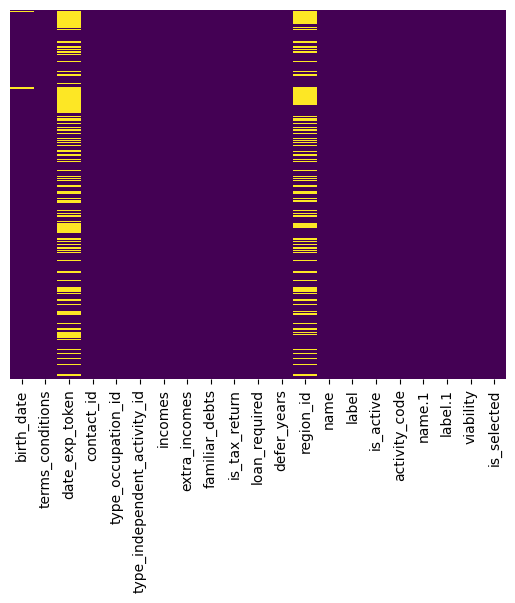

In [97]:
sns.heatmap(habi_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [98]:
habi_df.head()

,birth_date,terms_conditions,date_exp_token,contact_id,type_occupation_id,type_independent_activity_id,incomes,extra_incomes,familiar_debts,is_tax_return,...,defer_years,region_id,name,label,is_active,activity_code,name.1,label.1,viability,is_selected
0,1998-05-30,1,2022-11-25 23:13:29.0,1767,1,1,1500000,700000,0,0,...,0,26.0,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,1,0
1,1998-05-30,1,2022-11-25 23:13:29.0,1767,1,1,1500000,700000,0,0,...,0,26.0,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,0,0
2,1984-07-08,0,2023-01-16 18:16:50.0,23963,1,1,4781830,0,0,1,...,0,1.0,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,1,1
3,1985-02-14,0,NaN,23965,1,1,9000000,1000000,0,1,...,0,11.0,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,1,1
4,1997-01-09,0,NaN,24370,1,1,8000000,0,0,1,...,0,NaN,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,1,1


In [99]:
habi_df[['name','label']].groupby(['name','label']).size() 

name                                               label                                             
agriculture, livestock, hunting, forestry fishing  Agricultura, Ganadería, Caza, Silvicultura y Pesca      66
association and repair activities                  Actividades de Asociación y Reparación                  47
manufacture                                        Industrias Manufactureras                              130
other personal services activities                 Otras Actividades de Servicios Personales              537
others                                             Otros                                                 1244
professional scientif and technical activities     Actividades Profesionales, Ciéntificas y Técnicas      777
real state activitys                               Actividades Inmobiliarias                              189
transport and storage                              Transporte y Almacenamiento                            169
wholesale and reta

In [100]:
habi_df[['name.1','label.1']].groupby(['name.1','label.1']).size() 


name.1       label.1      
employee     Asalariado        118
independent  Independiente    3825
retired      Pensionado          1
dtype: int64

In [101]:
repeated_columns = ["label",  'label.1' ]
habi_df = habi_df.drop(columns=repeated_columns)

* el dataset es inbalanceado

In [102]:
habi_df['viability'].value_counts()

viability
1    2698
0    1246
Name: count, dtype: int64

In [103]:
habi_df.head()

,birth_date,terms_conditions,date_exp_token,contact_id,type_occupation_id,type_independent_activity_id,incomes,extra_incomes,familiar_debts,is_tax_return,loan_required,defer_years,region_id,name,is_active,activity_code,name.1,viability,is_selected
0,1998-05-30,1,2022-11-25 23:13:29.0,1767,1,1,1500000,700000,0,0,0,0,26.0,"wholesale and retail, auto repair",1,3,employee,1,0
1,1998-05-30,1,2022-11-25 23:13:29.0,1767,1,1,1500000,700000,0,0,0,0,26.0,"wholesale and retail, auto repair",1,3,employee,0,0
2,1984-07-08,0,2023-01-16 18:16:50.0,23963,1,1,4781830,0,0,1,0,0,1.0,"wholesale and retail, auto repair",1,3,employee,1,1
3,1985-02-14,0,NaN,23965,1,1,9000000,1000000,0,1,0,0,11.0,"wholesale and retail, auto repair",1,3,employee,1,1
4,1997-01-09,0,NaN,24370,1,1,8000000,0,0,1,0,0,NaN,"wholesale and retail, auto repair",1,3,employee,1,1


In [105]:
habi_df.columns

Index(['birth_date', 'terms_conditions', 'date_exp_token', 'contact_id',
       'type_occupation_id', 'type_independent_activity_id', 'incomes',
       'extra_incomes', 'familiar_debts', 'is_tax_return', 'loan_required',
       'defer_years', 'region_id', 'name', 'is_active', 'activity_code',
       'name.1', 'viability', 'is_selected'],
      dtype='object')

In [104]:

def proba_plot(df:pd.DataFrame,feature:str):
    probabilities = df.groupby([feature, 'viability']).size() / df.groupby(feature).size()
    probabilities = probabilities.reset_index().rename(columns={0: 'Probability'})
    pivot_df = probabilities.pivot(index=feature, columns='viability', values='Probability')
    pivot_df.plot(kind='bar', stacked=False)
    plt.title('Probabilities of Class Combinations')
    plt.xlabel(feature)
    plt.ylabel('Probability')
    plt.show()

terms_conditions


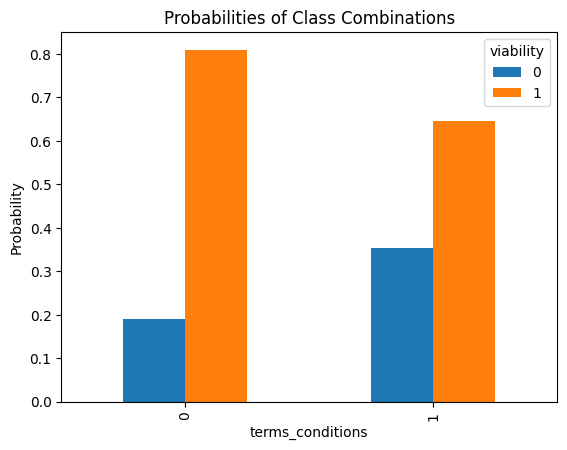

type_occupation_id


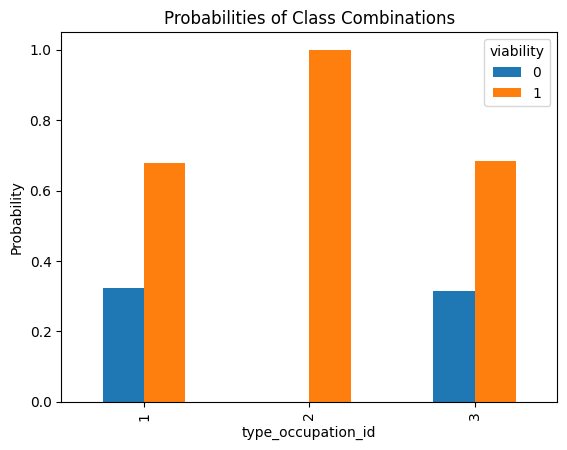

type_independent_activity_id


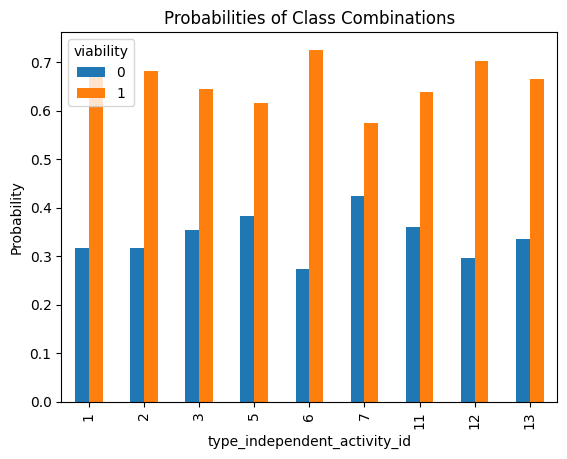

familiar_debts


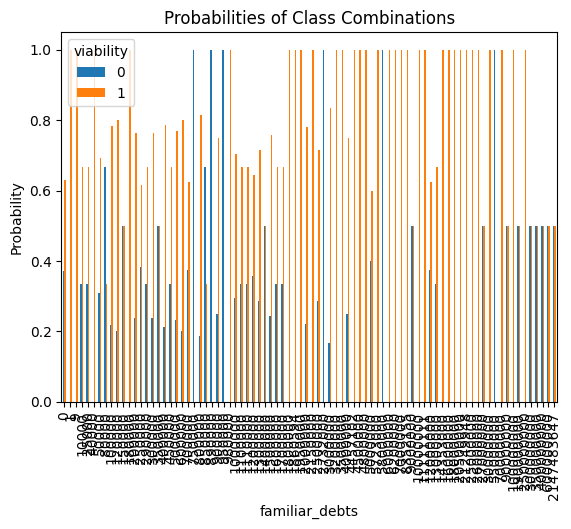

is_tax_return


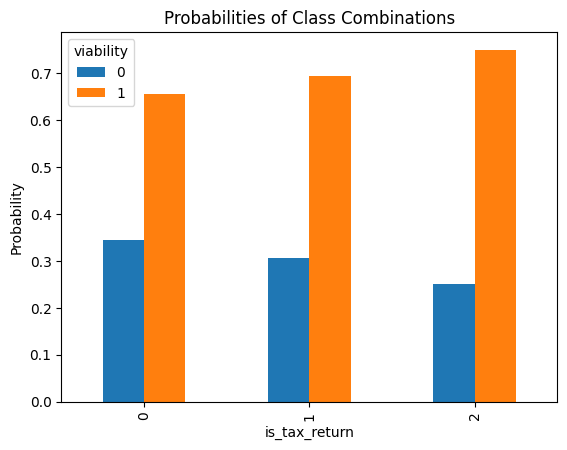

loan_required


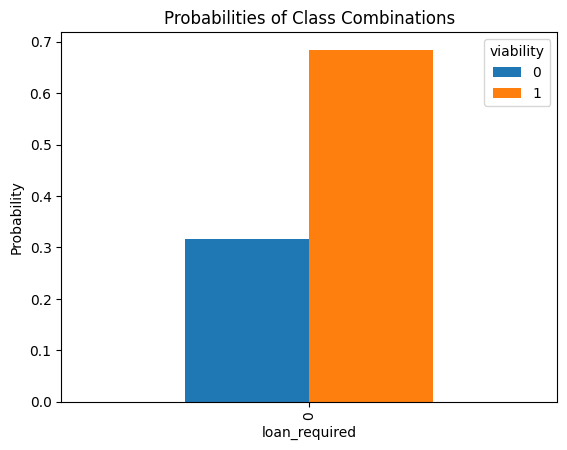

defer_years


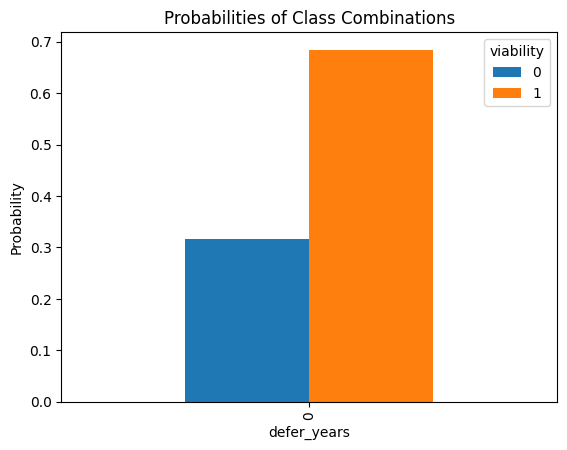

is_active


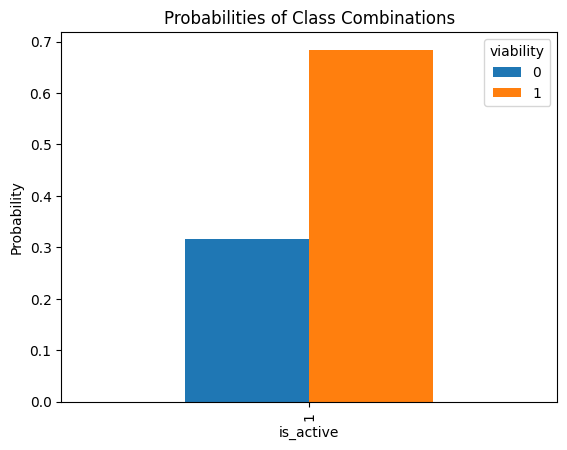

activity_code


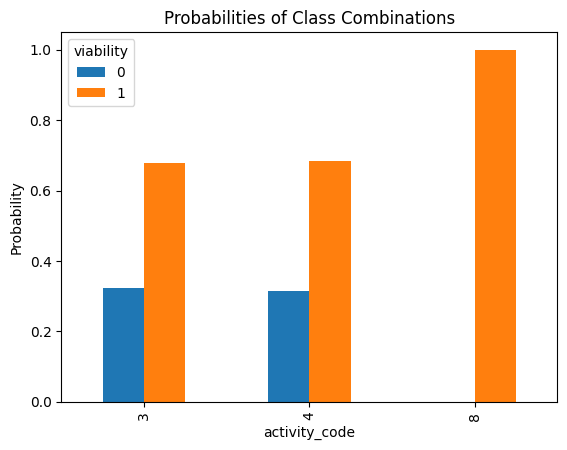

is_selected


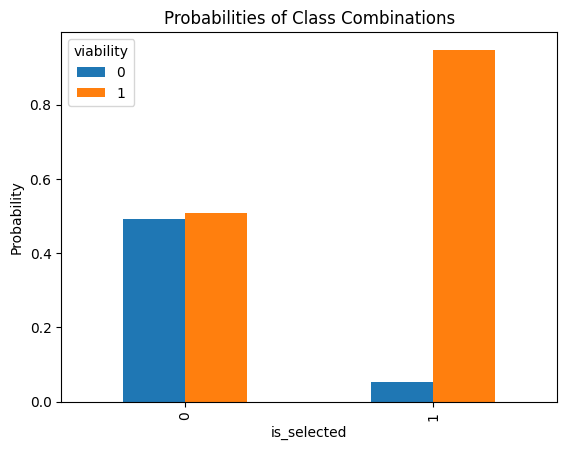

In [106]:
categorical = ['terms_conditions','type_occupation_id','type_independent_activity_id','familiar_debts', 'is_tax_return', 'loan_required',  'defer_years','is_active','activity_code','is_selected']

for c in categorical:
    print(c)
    proba_plot(habi_df,c)

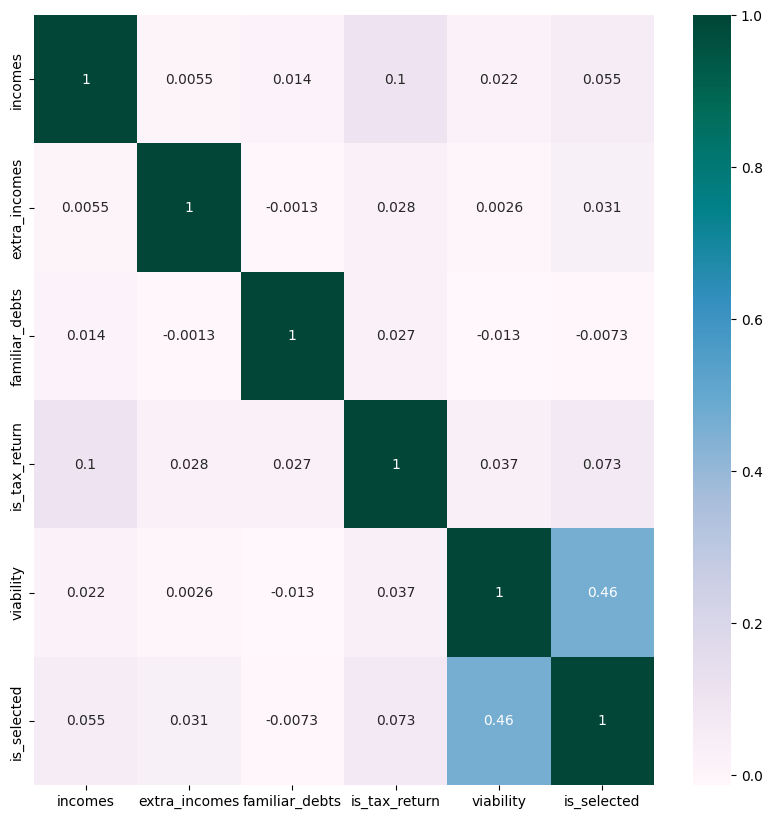

In [107]:
plt.figure(figsize=(10,10))
plt.rc('font', size=10)
hm=sns.heatmap((habi_df[['incomes','extra_incomes','familiar_debts','is_tax_return','viability','is_selected']].corr()),cmap="PuBuGn",annot=True)

In [113]:
habi_df

,birth_date,terms_conditions,date_exp_token,contact_id,type_occupation_id,type_independent_activity_id,incomes,extra_incomes,familiar_debts,is_tax_return,loan_required,defer_years,region_id,name,is_active,activity_code,name.1,viability,is_selected
0,1998-05-30,1,2022-11-25 23:13:29.0,1767,1,1,1500000,700000,0,0,0,0,26.0,"wholesale and retail, auto repair",1,3,employee,1,0
1,1998-05-30,1,2022-11-25 23:13:29.0,1767,1,1,1500000,700000,0,0,0,0,26.0,"wholesale and retail, auto repair",1,3,employee,0,0
2,1984-07-08,0,2023-01-16 18:16:50.0,23963,1,1,4781830,0,0,1,0,0,1.0,"wholesale and retail, auto repair",1,3,employee,1,1
3,1985-02-14,0,NaN,23965,1,1,9000000,1000000,0,1,0,0,11.0,"wholesale and retail, auto repair",1,3,employee,1,1
4,1997-01-09,0,NaN,24370,1,1,8000000,0,0,1,0,0,NaN,"wholesale and retail, auto repair",1,3,employee,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3939,1984-08-14,1,2023-05-30 22:46:49.0,31717,3,13,6000000,0,100000,1,0,0,13.0,other personal services activities,1,4,independent,0,0
3940,1987-03-01,1,2023-05-31 14:54:34.0,31741,3,13,7000000,0,0,1,0,0,13.0,other personal services activities,1,4,independent,1,0
3941,1987-03-01,1,2023-05-31 14:54:34.0,31741,3,13,7000000,0,0,1,0,0,13.0,other personal services activities,1,4,independent,1,1
3942,1992-08-25,0,NaN,31762,3,13,3000000,0,0,1,0,0,NaN,other personal services activities,1,4,independent,1,1


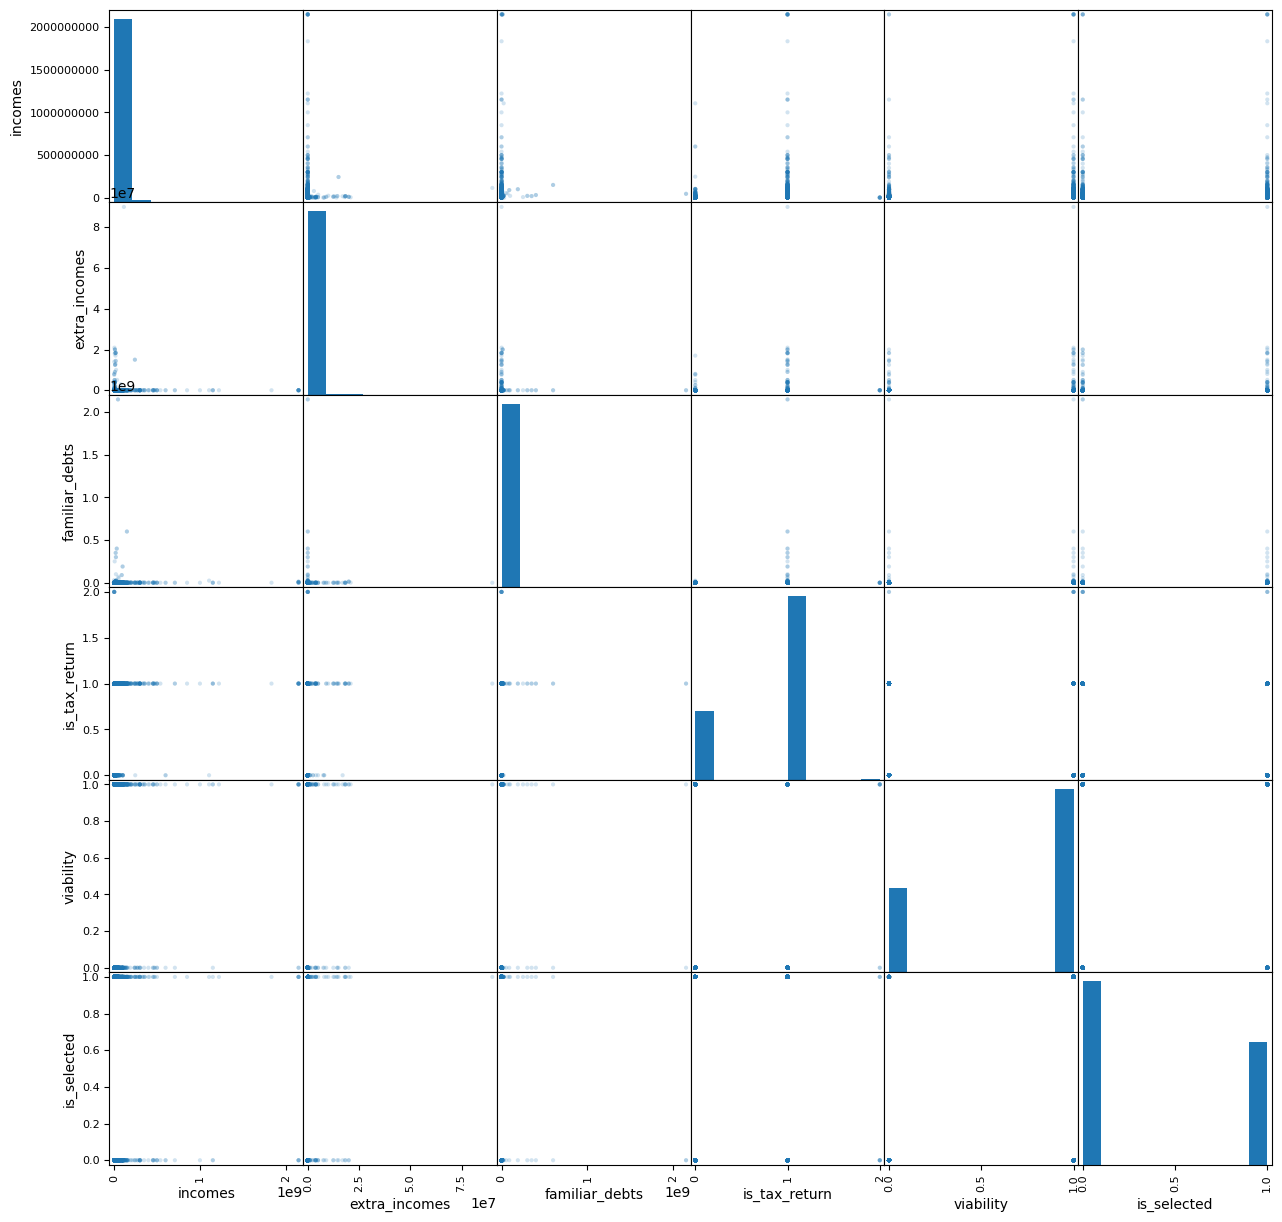

In [121]:
pd.plotting.scatter_matrix(habi_df[['incomes','extra_incomes','familiar_debts','is_tax_return','viability','is_selected']], alpha=0.2,figsize=(15,15))
print()

In [131]:
from sklearn.metrics import mutual_info_score

def mutual_info_churn_score(series):
    return mutual_info_score(series,habi_df['viability'])


mi = habi_df[categorical].apply(mutual_info_churn_score)
mi.sort_values(ascending=False)

is_selected                     0.126199
familiar_debts                  0.019439
terms_conditions                0.011683
type_independent_activity_id    0.001834
is_tax_return                   0.000671
type_occupation_id              0.000099
activity_code                   0.000099
loan_required                   0.000000
defer_years                     0.000000
is_active                       0.000000
dtype: float64

# Train

In [133]:
from sklearn.model_selection import train_test_split

partial = habi_df[['incomes','extra_incomes','familiar_debts','is_tax_return','viability','is_selected']]
# Extract feature and target arrays
X, y = partial.drop('viability', axis=1), partial['viability']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)



In [134]:
import xgboost as xgb
from sklearn.metrics import accuracy_score


xgb_cl = xgb.XGBClassifier()

# Fit
xgb_cl.fit(X_train, y_train)

# Predict
preds = xgb_cl.predict(X_test)

accuracy_score(y_test, preds)

0.6480730223123732

[Text(0.5, 58.7222222222222, 'Predicted'),
 Text(70.72222222222221, 0.5, 'Actual')]

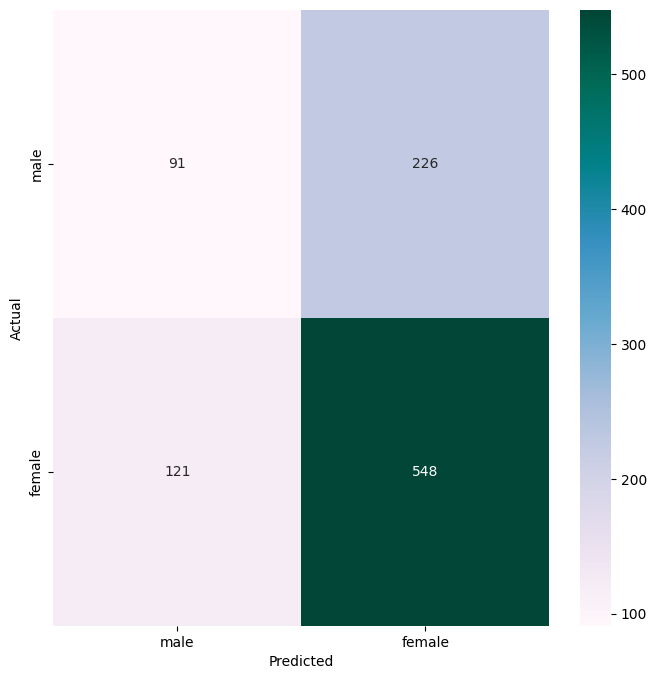

In [136]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, preds,labels=[0,1])
cm_df = pd.DataFrame(cm ,columns=['male','female'],index=['male','female'])
plt.figure(figsize=(8, 8))
plot =sns.heatmap(cm_df,cmap="PuBuGn",annot=True,fmt='g')
plot.set(xlabel='Predicted', ylabel='Actual')

In [138]:
print(classification_report(y_test, preds, labels=[0,1]))


              precision    recall  f1-score   support

           0       0.43      0.29      0.34       317
           1       0.71      0.82      0.76       669

    accuracy                           0.65       986
   macro avg       0.57      0.55      0.55       986
weighted avg       0.62      0.65      0.63       986



In [139]:
from sklearn.metrics import roc_auc_score

score = roc_auc_score(y_test, preds)
round(score,3)

0.553